# This notebook trains and evaluates AllLingLog on HDFS dataset. 
## Requirements

1. `torch==2.7.1+cu128`
2. `numpy==2.3.1`
3. `pandas==2.3.1`
4. `scikit-learn==1.7.0`
5. `tqdm==4.67.1`
6. `tiktoken==0.9.0`
7. `linformer==0.2.3`
8. `psutil==7.0.0`
9. `matplotlib==3.10.3`



In [2]:
#########################################################################
# This cell read the public log dataset from /logs/HDFS.log.
# Tokenizing the logs and creating input features for the model.
# Input features was splitted as test set (70%), validation set (15%) 
# and test set (15%)
##########################################################################
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW 
from torch.nn.utils.rnn import pad_sequence
from transformers import GPT2Tokenizer
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score as f1_score_sklearn
from tqdm import tqdm
import time
from datetime import datetime
import pandas as pd
import re 
import tiktoken
import random

beta = 0.4

max_token_length = 18000 #set an initial value for the max token length

def set_seed(seed=42):
    """Set random seed for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")


class LogDataset(Dataset):
    def __init__(self, sessions):
        """
        Initializes the dataset with a list of session dictionaries.
        
        Each session dictionary is expected to contain the keys:
          - 'block_id'
          - 'input_ids'
          - 'segment_ids'
          - 'session_label'
        """
        self.sessions = sessions

    def __len__(self):
        return len(self.sessions)

    def __getitem__(self, idx):
        session = self.sessions[idx]
        # Return a dictionary containing only the required three items.
        compact_session = {
            'input_ids': session['input_ids'],
            'segment_ids': session['segment_ids'],
            'session_label': session['session_label']
        }
        return compact_session

# --- Helper Functions and Tokenizer Loading ---

def clean(text):
    """Cleans a log message by removing special characters and extra spaces."""
    import re
    import string
    text = re.sub(r'\]|\[|\)|\(|\=|\,|\;', ' ', text)
    text = " ".join([word.lower() if word.isupper() else word for word in text.strip().split()])
    text = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', text))
    return " ".join([word.lower().strip() for word in text.strip().split()])

# function to load the pre-trained GPT4 BPE tokenizer 
def load_gpt4_tokenizer():
    print("Loading cl100k_base (GPT-4) tokenizer...")
    tokenizer = tiktoken.get_encoding("cl100k_base")
    return tokenizer

# Tokenize logs with the pre-trained GPT-4 tokenizer 
def tokenize_and_construct_input(log_sequence, tokenizer, max_len):
    """
    Tokenize log messages and construct input IDs and segment IDs.
    Adds beginning-of-sequence (bos) and end-of-sequence (eos) tokens, and assigns
    segment IDs based on the log position.
    """
    input_ids = []
    segment_ids = []

    allowed_special = {"<|startoftext|>", "<|endoftext|>"}
    bos_token = tokenizer.encode("<|startoftext|>", allowed_special=allowed_special)[0] # get the token id of <|startoftext|>
    eos_token = tokenizer.encode("<|endoftext|>", allowed_special=allowed_special)[0] # get the token id of <|endoftext|>
    
    for i, log in enumerate(log_sequence):
        # Tokenize the log message
        tokens = tokenizer.encode(log, allowed_special={"<|startoftext|>", "<|endoftext|>"})
        
        # Add bos_token to the first log only in the sequence
        if i == 0:  # First log in sequence
            tokens = [bos_token] + tokens  # <|startoftext|> + log tokens
        tokens = tokens + [eos_token]  # <|endoftext|> appended to the log tokens
        
        input_ids.extend(tokens)
        segment_ids.extend([i] * len(tokens))
    
    if len(input_ids) > max_len:
        print(f"Warning: Sequence length {len(input_ids)} exceeds max length {max_len}. Truncating.")
        input_ids = input_ids[:max_len]
        segment_ids = segment_ids[:max_len]
    
    return input_ids, segment_ids

# --- Modified Oversampling Function ---
def oversample_with_ratio_control(sessions, beta):
    """
    Oversample the minority class to achieve a specific proportion (beta) in the dataset.
    If no anomalous sessions are found, a warning is printed and the original sessions are returned.
    """
    normal_sessions = [s for s in sessions if s["session_label"] == 0]
    anomalous_sessions = [s for s in sessions if s["session_label"] == 1]
    
    if len(anomalous_sessions) == 0:
        print("Warning: No anomalous sessions found. Skipping oversampling.")
        return sessions  # Return the sessions unchanged
    
    normal_count = len(normal_sessions)
    anomalous_count = len(anomalous_sessions)
    total_count = normal_count + anomalous_count
    
    alpha = anomalous_count / total_count
    target_minority_size = int((beta * (1 - alpha) / (1 - beta)) * total_count)
    new_added_anomalous = target_minority_size - anomalous_count

    if target_minority_size <= anomalous_count:
        print("No oversampling needed. Current minority size meets the target proportion.")
        return sessions

    # Oversample anomalous sessions with replacement
    new_added_anomalous = np.random.choice(anomalous_sessions, size=new_added_anomalous, replace=True)
    oversampled_sessions = normal_sessions + anomalous_sessions + list(new_added_anomalous)
    final_anomalous_count = len(anomalous_sessions) + len(new_added_anomalous)
    np.random.shuffle(oversampled_sessions)

    
    
    print(f"Original Minority Samples: {anomalous_count}")
    print(f"New Target Minority Size: {target_minority_size}")
    print(f"New Total Samples: {len(oversampled_sessions)}")
    print(f"New Anomalous to Total ratio: {final_anomalous_count / len(oversampled_sessions):.2f}")
    return oversampled_sessions

# --- Modified Session Creation Function ---
def create_sessions_with_segment_ids(log_data, tokenizer, window, label_file=None):
    """
    Process log data into sessions with input IDs and segment IDs.
    Each session is defined by a unique block ID. For debugging purposes,
    the session dictionary now includes the block ID.
    """
    if window != 'session':
        raise ValueError("Currently only window='session' is supported for the HDFS dataset.")

    # Group logs by block ID.
    session_dict = {}
    for line in tqdm(log_data, desc="Grouping logs by session"):
        tokens = line.split()
        if len(tokens) < 2:
            continue
        try:
            timestamp_str = " ".join(tokens[:2])
            timestamp = datetime.strptime(timestamp_str, '%y%m%d %H%M%S').timestamp()
        except Exception as ex:
            print(f"Timestamp parsing error: {ex} in line: {line}")
            continue
        
        blk_ids = list(set(re.findall(r'(blk_-?\d+)', line)))
        if len(blk_ids) != 1:
            continue
        blk_id = blk_ids[0]
        if clean_log == True:
            cleaned_line = clean(line)
        else:
            cleaned_line = line        

        if blk_id not in session_dict:
            session_dict[blk_id] = []
        session_dict[blk_id].append((timestamp, cleaned_line))
    
    # Load label mapping if provided.
    label_mapping = {}
    if label_file:
        label_df = pd.read_csv(label_file, engine='c', na_filter=False)
        label_df = label_df.set_index("BlockId")
        label_mapping = label_df["Label"].to_dict()
    
    sessions = []
    for blk_id, events in tqdm(session_dict.items(), desc="Processing sessions"):
        events.sort(key=lambda x: x[0])
        log_sequence = [msg for (ts, msg) in events]
        if label_file:
            session_label = 1 if label_mapping.get(blk_id, "Normal") == "Anomaly" else 0
        else:
            session_label = 0
        input_ids, segment_ids = tokenize_and_construct_input(log_sequence, tokenizer,max_token_length)
        sessions.append({
            "block_id": blk_id,   
            "input_ids": input_ids,
            "segment_ids": segment_ids,
            "session_label": session_label
        })
    return sessions

# --- Modified Main Loading Function ---
def load_HDFS_with_gpt4_bpe_stratified(
    log_file, 
    train_ratio=0.7, 
    val_ratio=0.15, 
    test_ratio=0.15, 
    window='session', 
    label_file=None
):
    """
    Load logs, create sessions, and perform a stratified train/val/test split based on session labels.
    Uses a subset of log events (e.g., first 10,000) for quick testing.
    """
    print("Loading logs from:", log_file)
    start_time = time.time()

    # Read logs and create sessions.
    with open(log_file, mode="r", encoding='utf8') as f:
       logs = [x.strip() for x in tqdm(f, desc="Reading Logs")]
    #logs = logs[:100000]  # For testing purposes
    print(f"Loaded {len(logs)} logs in {time.time() - start_time:.2f} seconds.")

    # Load GPT-4 tokenizer.
    tokenizer = load_gpt4_tokenizer()

    # Create sessions from logs.
    all_sessions = create_sessions_with_segment_ids(logs, tokenizer, window, label_file=label_file)

    #calculate the number of length that fit XX% of the sessions 
    token_lengths = [len(session["input_ids"]) for session in all_sessions]
    max_len_90 = int(np.percentile(token_lengths, 90))
    max_len_95 = int(np.percentile(token_lengths, 95))
    max_token_length = max(token_lengths)
    print(f"Max tokens in 90% of sessions: {max_len_90}")
    print(f"Max tokens in 95% of sessions: {max_len_95}")
    print(f"Max tokens in 100% of sessions: {max_token_length}") 

    
    # Debug: Print first 10 session block IDs and labels.
    # print("First 10 session block IDs and labels:")
    # for session in all_sessions[:10]:
    #     print(f"Block ID: {session['block_id']}  => Label: {session['session_label']}")

    # Check overlap between session block IDs and label file block IDs.
    if label_file:
        label_df = pd.read_csv(label_file, engine='c', na_filter=False)
        label_df = label_df.set_index("BlockId")
        label_mapping = label_df["Label"].to_dict()
        session_block_ids = {session["block_id"] for session in all_sessions}
        label_block_ids = set(label_mapping.keys())
        common_ids = session_block_ids.intersection(label_block_ids)
        print("Total unique session block IDs:", len(session_block_ids))
        print("Total block IDs in label file:", len(label_block_ids))
        print("Number of block IDs common to both:", len(common_ids))

    # Stratified train/val/test split.
    session_labels = [s["session_label"] for s in all_sessions]
    # First split: train and temp (val+test)
    train_sessions, temp_sessions, train_labels, temp_labels = train_test_split(
        all_sessions,
        session_labels,
        test_size=(1 - train_ratio),
        stratify=session_labels,
        random_state=42
    )
    # Compute val and test ratios relative to temp
    val_relative = val_ratio / (val_ratio + test_ratio)
    temp_labels = [s["session_label"] for s in temp_sessions]
    val_sessions, test_sessions, val_labels, test_labels = train_test_split(
        temp_sessions,
        temp_labels,
        test_size=(1 - val_relative),
        stratify=temp_labels,
        random_state=42
    )
    print(f"Number of sessions: {len(all_sessions)}. Train: {len(train_sessions)}, Val: {len(val_sessions)}, Test: {len(test_sessions)}")

    # Print class distribution for each split
    def print_split_stats(name, sessions):
        normal = sum(s['session_label'] == 0 for s in sessions)
        anomalous = sum(s['session_label'] == 1 for s in sessions)
        ratio = anomalous / (normal + anomalous)
        print(f"{name} => Normal: {normal} | Anomalous: {anomalous}")
        print(f"Anomalous to Total samples ratio in {name}: {ratio:.4f}")

    print_split_stats("Train set", train_sessions)
    print_split_stats("Validation set", val_sessions)
    print_split_stats("Test set", test_sessions)

    # Balance training data with oversampling.
    print("Balancing training data with oversampling...")
    train_sessions = oversample_with_ratio_control(train_sessions, beta)
    print(f"Balanced training data: {len(train_sessions)} samples")
    print(f"Total processing time: {time.time() - start_time:.2f} seconds.")

    return train_sessions, val_sessions, test_sessions, tokenizer

# --- Main Execution ---
if __name__ == "__main__":
    log_file = "./logs/HDFS.log"
    label_file = "./logs/anomaly_label_HDFS.csv"
    window = 'session'
    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15
    beta = 0.4
    clean_log = False
    set_seed(42)  # Set random seed for reproducibility

    training_sessions, validation_sessions, test_sessions, tokenizer = load_HDFS_with_gpt4_bpe_stratified(
        log_file, 
        train_ratio=train_ratio, 
        val_ratio=val_ratio,
        test_ratio=test_ratio,
        window=window,
        label_file=label_file
    )

    # Validate sessions by printing a few tokenized sessions.
    def validate_sessions(sessions, tokenizer, window):
        print("=========== Start of Validate Sessions =====================")
        print(f"Number of sessions: {len(sessions)}")
        for idx, session in enumerate(sessions[:5]):
            print(f"\nSession {idx + 1}:")
            print(f"Block ID: {session['block_id']}")
            print(f"Input IDs: {session['input_ids']}")
            print(f"Segment IDs: {session['segment_ids']}")
            print(f"Session Label: {session['session_label']}")
            decoded_log = tokenizer.decode(session["input_ids"])
            print(f"Decoded Log: {decoded_log}")
    
    validate_sessions(training_sessions, tokenizer, window)

    # calculate the average token and max tokens in the sessions

    token_lengths = [len(session["input_ids"]) for session in training_sessions]
    max_token_length = max(token_lengths)
    print(f"Average tokens per session: {sum(token_lengths) / len(token_lengths):.2f}")
    print(f"Max tokens in a session: {max_token_length}")

Random seed set to 42
Loading logs from: ./logs/HDFS.log


Reading Logs: 11175629it [00:05, 2111521.92it/s]


Loaded 11175629 logs in 5.29 seconds.
Loading cl100k_base (GPT-4) tokenizer...


Processing sessions: 100%|██████████| 575061/575061 [04:09<00:00, 2305.98it/s]


Max tokens in 90% of sessions: 1210
Max tokens in 95% of sessions: 1362
Max tokens in 100% of sessions: 15166
Total unique session block IDs: 575061
Total block IDs in label file: 575061
Number of block IDs common to both: 575061
Number of sessions: 575061. Train: 402542, Val: 86259, Test: 86260
Train set => Normal: 390755 | Anomalous: 11787
Anomalous to Total samples ratio in Train set: 0.0293
Validation set => Normal: 83734 | Anomalous: 2525
Anomalous to Total samples ratio in Validation set: 0.0293
Test set => Normal: 83734 | Anomalous: 2526
Anomalous to Total samples ratio in Test set: 0.0293
Balancing training data with oversampling...
Original Minority Samples: 11787
New Target Minority Size: 260503
New Total Samples: 651258
New Anomalous to Total ratio: 0.40
Balanced training data: 651258 samples
Total processing time: 348.34 seconds.
=========== Start of Validate Sessions =====================
Number of sessions: 651258

Session 1:
Block ID: blk_2858264170709179290
Input IDs: [

In [3]:
##############################################################################
# implement the embedding layers 
##############################################################################

cl100k_vocab_size = 100264 # GPT4 BPE
#segment_ids_size = 20  # for BGL  segment_vocab_size =  segment_ids_size = 20
embedding_dimension = 128
length_95_percentile = 1531 # for HDFS datase
max_token_length = max_token_length  

class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size=cl100k_vocab_size, max_seq_len=max_token_length, segment_vocab_size=100, embedding_dim=128):   
        super(EmbeddingLayer, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)          # GPT-2 vocab size
        self.segment_embedding = nn.Embedding(segment_vocab_size, embedding_dim)  # For segment IDs
        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)     # For position IDs

    def forward(self, input_ids, segment_ids, position_ids=None):
        # Automatically generate position_ids if not provided
        if position_ids is None:
            position_ids = torch.arange(input_ids.size(1), device=input_ids.device).unsqueeze(0).repeat(input_ids.size(0), 1)
        
        E_token = self.token_embedding(input_ids)         # (batch_size, seq_len, embedding_dim)
        E_segment = self.segment_embedding(segment_ids)   # (batch_size, seq_len, embedding_dim)
        E_position = self.position_embedding(position_ids) # (batch_size, seq_len, embedding_dim)
        return E_token + E_segment + E_position


In [4]:
###################################################################
# Construct linear self-attention encoder via linformer
# Final AllLinLog model
###################################################################
from linformer import Linformer
import torch
import torch.nn as nn

max_token_length = max_token_length  # Use the max token length from your dataset

# Updated Transformer Encoder Layer using Linformer
class LinformerEncoderLayer(nn.Module):
    
    def __init__(self, embedding_dim=128, num_heads=2, ff_hidden_dim=128, seq_len=max_token_length, k=128, dropout=0.1):
        """
        A single Linformer encoder layer.

        Args:
        - embedding_dim: Input embedding dimension.
        - num_heads: Number of attention heads.
        - ff_hidden_dim: Hidden dimension of the feed-forward network.
        - k: Low-rank approximation factor for attention.
        - dropout: Dropout rate.
        """
        super(LinformerEncoderLayer, self).__init__()
        self.self_attention = Linformer(
            dim=embedding_dim,
            seq_len=int(seq_len),  # Sequence length from your max_token_length
            depth=1,  # Single depth for this layer
            heads=num_heads,
            k=k,  # Low-rank approximation
            one_kv_head=True,
            share_kv=True
        )
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, embedding_dim)
        )
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention with residual connection
        attention_output = self.self_attention(x)
        x = self.norm1(x + self.dropout(attention_output))

        # Feed-forward network with residual connection
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x

# Linformer-based Transformer Encoder
class LinformerTransformerEncoder(nn.Module):
    def __init__(self, num_layers=1, embedding_dim=128, seq_len=max_token_length, num_heads=2, ff_hidden_dim=128, k=128, dropout=0.1):
        """
        Multi-layer Linformer-based Transformer encoder.

        Args:
        - num_layers: Number of Linformer encoder layers.
        - embedding_dim: Input embedding dimension.
        - num_heads: Number of attention heads.
        - ff_hidden_dim: Hidden dimension of the feed-forward network.
        - k: Low-rank approximation factor for attention.
        - dropout: Dropout rate.
        """
        super(LinformerTransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            LinformerEncoderLayer(embedding_dim, num_heads, ff_hidden_dim, seq_len, k, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define the AllLinLog model using the Linformer encoder
class AllLinLog(nn.Module):
    def __init__(self, vocab_size=cl100k_vocab_size, max_seq_len=max_token_length, segment_vocab_size=20, embedding_dim=128, 
                 num_layers=1, num_heads=2, ff_hidden_dim=128, k=128, num_classes=2, dropout=0.1, max_segment_lengths=100):
        super(AllLinLog, self).__init__()
        self.embedding_layer = EmbeddingLayer(vocab_size, max_seq_len, segment_vocab_size=max_segment_lengths, embedding_dim=embedding_dim)
        self.encoder = LinformerTransformerEncoder(num_layers, embedding_dim, max_seq_len, num_heads, ff_hidden_dim, k, dropout)
        self.fc = nn.Linear(embedding_dim, num_classes)  # Final classification layer

    def forward(self, input_ids, segment_ids, position_ids, attention_mask=None):
        embeddings = self.embedding_layer(input_ids, segment_ids, position_ids)  # (batch_size, seq_len, embedding_dim)
        encoder_output = self.encoder(embeddings)  # (batch_size, seq_len, embedding_dim)
        pooled_output = torch.mean(encoder_output, dim=1)  # Average pooling for session-level representation
        logits = self.fc(pooled_output)  # (batch_size, num_classes)
        return logits



Max segment length set to: 298
Random seed set to 42
running with k = 32
Total Parameters: 15501506
Model Size: 59.13 MB
Input IDs: torch.Size([8, 1058]), Segment IDs: torch.Size([8, 1058])
Attention Masks: torch.Size([8, 1058]), Session Labels: torch.Size([8])
Epoch 1/1


Formatted Classification Report:
             precision   recall f1-score  support
Normal         0.99988  0.99927  0.99958  83734.0
Anomalous      0.97632  0.99604  0.98608   2525.0
accuracy       0.99918  0.99918  0.99918      NaN
macro avg      0.98810  0.99766  0.99283  86259.0
weighted avg   0.99919  0.99918  0.99918  86259.0
Train Loss: 0.01662, Train Accuracy: 0.99478
Val Loss: 0.01058, Val Accuracy: 0.99918
Anomalous Precision: 0.97632, Anomalous Recall: 0.99604, Anomalous F1 Score: 0.98608
Training time for one epoch: 19.27 minutes
The Memory initial allocated beform training: 313.02 MB
Memory Used for training in this epoch: 177.68 MB

Learning Rate: 5.0e-04
New best model saved as : best_model_HDFS/best_model_HDFS20250825_195805.pth 

Average Training Time per Epoch: 19.272077445189158 min
Peak GPU Memoryy Allocated: 1800.84 MB


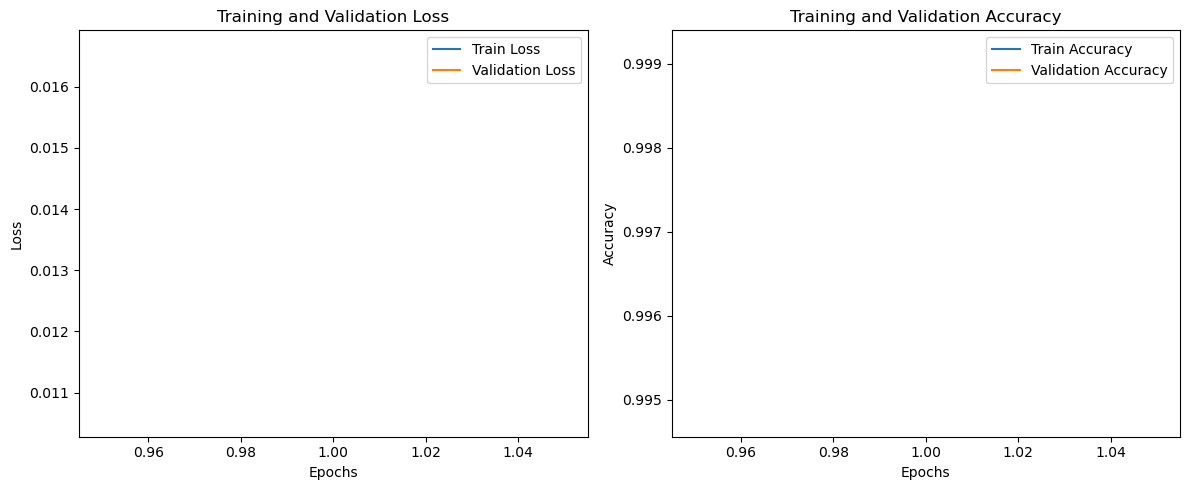


Evaluating best model on test set...
Loaded best model from best_model_HDFS/best_model_HDFS20250825_195805.pth


Formatted Classification Report:
             precision   recall f1-score  support
Normal         0.99984  0.99928  0.99956  83734.0
Anomalous      0.97668  0.99485  0.98568   2526.0
accuracy       0.99915  0.99915  0.99915      NaN
macro avg      0.98826  0.99707  0.99262  86260.0
weighted avg   0.99917  0.99915  0.99916  86260.0

 Unbiased Test Classification Report:
             precision   recall f1-score  support
Normal         0.99984  0.99928  0.99956  83734.0
Anomalous      0.97668  0.99485  0.98568   2526.0
accuracy       0.99915  0.99915  0.99915      NaN
macro avg      0.98826  0.99707  0.99262  86260.0
weighted avg   0.99917  0.99915  0.99916  86260.0
Loaded best model from best_model_HDFS/best_model_HDFS20250825_195805.pth
Average Inference Time: 0.70 ms
Memory Used During Inference: 0.00 MB
Peak GPU Memory Allocated: 1800.84 MB
Latest results file: results_HDFS/results_HDFS20250825_195805.txt


In [ ]:
##############################################################################
# Create the dataloaders 
# Training and Evaluation Pipeline
# Output is placed into /results_HDFS
# The best model is saved to /best_model_HDFS
###############################################################################
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score as f1_score_sklearn
import matplotlib.pyplot as plt
import os
import glob
import datetime
from linformer import Linformer
import psutil
import random

def generate_classification_report(all_labels, all_preds):
    # Generate the classification report as a dictionary
    target_names = ["Normal", "Anomalous"]  # Adjust based on your dataset's classes
    report_dict = classification_report(
        all_labels, 
        all_preds, 
        target_names=target_names, 
        output_dict=True,
        zero_division=0  # avoid warning for undefined metrics
        )


    # Convert the dictionary to a pandas DataFrame
    report_df = pd.DataFrame(report_dict).transpose()

    # Format numeric columns to desired precision
    report_df['precision'] = report_df['precision'].apply(lambda x: f"{x:.5f}")
    report_df['recall'] = report_df['recall'].apply(lambda x: f"{x:.5f}")
    report_df['f1-score'] = report_df['f1-score'].apply(lambda x: f"{x:.5f}")
    report_df['support'] = report_df['support'].apply(lambda x: int(x) if not pd.isna(x) else "")  # Format support as integer

    # Remove support for the accuracy row
    report_df.loc['accuracy', 'support'] = np.nan  # Use NaN for missing numeric values

    print("Formatted Classification Report:")
    print(report_df)

    # Optionally, save the report to a CSV or text file
    report_df.to_csv('classification_report.csv', index=True)
    return report_df

class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=10, patience=20, device='cpu'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.patience = patience
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.total_time = 0
        self.timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

        # Create necessary folders
        os.makedirs('results_HDFS', exist_ok=True)
        os.makedirs('best_model_HDFS', exist_ok=True)

    def train(self):
        best_val_loss = float('inf')
        best_val_f1 = 0.0
        patience_counter = 0   
        results_file = os.path.join('results_HDFS', f'results_HDFS{self.timestamp}.txt')
        best_model_file = os.path.join('best_model_HDFS', f'best_model_HDFS{self.timestamp}.pth')
        total_params, size_mb = compute_model_size(self.model)
        total_time_minutes = 0 
        memory_initial = 0

        with open(results_file, 'w') as f:
            f.write("Experiment Parameters:\n")
            f.write(f"log_file: {log_file}\n")
            #f.write(f"windows_size: {windows_size}\n") # not used for HDFS
            #f.write(f"step_size: {step_size}\n") # not used for HDFS
            f.write(f"train_ratio: {train_ratio}\n")
            f.write(f"beta: {beta}\n")
            f.write(f"batch_size: {batch_size}\n")
            f.write(f"dropout: {dropout}\n")
            f.write(f"num_layers: {num_layers}\n")
            f.write(f"num_heads: {num_heads}\n")
            f.write(f"k: {k}\n")
            f.write("\n")
            f.write(f"Total Parameters: {total_params}\n")
            f.write(f"Model Size: {size_mb:.2f} MB\n")
            memory_initial = measure_memory()
            epoch_run = 0
            for epoch in range(self.num_epochs):
                start_time = time.time()
                memory_before = measure_memory()
                epoch_run +=1
                print(f"Epoch {epoch + 1}/{self.num_epochs}")
                print(f"Epoch {epoch + 1}/{self.num_epochs}", file=f)

                # Training Phase
                train_loss, train_acc = self._train_one_epoch()
                epoch_time_minutes = (time.time() - start_time) / 60
                total_time_minutes += epoch_time_minutes

                memory_after = measure_memory()
                if memory_before == memory_after:
                    memory_before = memory_initial

                # Validation Phase
                val_loss, val_acc, Anomalous_val_precision, Anomalous_val_recall, Anomalous_val_f1, report_df = self._validate()

                # Log and Save Metrics
                self.train_losses.append(train_loss)
                self.train_accuracies.append(train_acc)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)
            
                # Log to console and file
                log = (
                    f"Train Loss: {float(train_loss):.5f}, Train Accuracy: {float(train_acc):.5f}\n"
                    f"Val Loss: {float(val_loss):.5f}, Val Accuracy: {float(val_acc):.5f}\n"
                    f"Anomalous Precision: {float(Anomalous_val_precision):.5f}, "
                    f"Anomalous Recall: {float(Anomalous_val_recall):.5f}, "
                    f"Anomalous F1 Score: {float(Anomalous_val_f1):.5f}\n"
                    f"Training time for one epoch: {float(epoch_time_minutes):.2f} minutes\n"
                    f"The Memory initial allocated beform training: {memory_initial:.2f} MB\n"
                    f"Memory Used for training in this epoch: {memory_after - memory_before:.2f} MB\n"
                )

                print(log)
                print(log, file=f)

                # Log the full classification report to the results file
                print("\nClassification Report:\n", file=f)
                print(report_df.to_string(), file=f)
                print("------------ END of Epoch --------------\n", file=f)

                # Scheduler Step
                self.scheduler.step(val_loss)
                current_lr = self.optimizer.param_groups[0]['lr']
                print(f"Learning Rate: {current_lr:.1e}")
                print(f"Learning Rate: {current_lr:.1e}", file=f)

                # Early Stopping Logic , can based on val_loss or Anmalous_val_f1
                if (val_loss < best_val_loss) or (Anomalous_val_f1 > best_val_f1):
                    best_val_loss = min(val_loss, best_val_loss)
                    best_val_f1 = max(Anomalous_val_f1, best_val_f1)
                    patience_counter = 0
                    torch.save(self.model.state_dict(), best_model_file)
                    print(f"New best model saved as : { best_model_file } \n")
                    print(f"New best model saved as : { best_model_file } \n", file=f)
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        print("Early stopping triggered.\n")
                        print("Early stopping triggered.\n", file=f)
                        break
            
            # average training time per epoch 
            avg_time_minutes = total_time_minutes / epoch_run
            print(f"Average Training Time per Epoch: {avg_time_minutes} min")
            print(f"Average Training Time per Epoch: {avg_time_minutes} min", file=f)

            # peak GPU memory allocated
            if torch.cuda.is_available():
                print(f"Peak GPU Memoryy Allocated: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
                print(f"Peak GPU Memoryy Allocated: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB", file=f)
            # Plot Training History
            self._plot_training_history()

    def _train_one_epoch(self):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        loop = tqdm(self.train_loader, desc="Training", leave=False)

        for batch in loop:
            input_ids, segment_ids, attention_masks, labels = [b.to(self.device) for b in batch]
            # Debug: Check that all labels are in {0, 1}
            if not torch.all((labels == 0) | (labels == 1)):
                print("Invalid label found in batch:", labels)
                raise ValueError("Target labels must be 0 or 1 for CrossEntropyLoss.")

            self.optimizer.zero_grad()

            logits = self.model(input_ids, segment_ids, attention_masks)
            loss = self.criterion(logits, labels)
            loss.backward()
            #----------addind for reduce overfitting ---------------
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            #--------------------------------------------------------
            self.optimizer.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), accuracy=correct / total)

        return total_loss / len(self.train_loader), correct / total

    def _validate(self):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        loop = tqdm(self.val_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for batch in loop:
                input_ids, segment_ids, attention_masks, labels = [b.to(self.device) for b in batch]
                logits = self.model(input_ids, segment_ids, attention_masks)
                loss = self.criterion(logits, labels)
                total_loss += loss.item()

                preds = logits.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                #--for debug, show the partial f1 score---
                # Compute partial F1 with current predictions
                partial_f1 = f1_score_sklearn(all_labels, all_preds, pos_label=1,zero_division=0)
                loop.set_postfix(partial_f1=f"{partial_f1:.5f}", loss=loss.item())
                
        # Generate formatted classification report
        report_df = generate_classification_report(all_labels, all_preds)
        # Extract specific metrics
        if "Anomalous" in report_df.index:
            precision = float(report_df.loc["Anomalous", "precision"])
            recall = float(report_df.loc ["Anomalous", "recall"])
            f1_score = float(report_df.loc["Anomalous", "f1-score"])
        else:
            precision, recall, f1_score = 0.0, 0.0, 0.0

        

        # Overall accuracy
        accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

        return total_loss / len(self.val_loader), accuracy, precision, recall, f1_score, report_df

    def measure_inference_time(self, input_sample, num_runs=100):
        """measure inference time and memory usage"""

        self.model.to(self.device)
        self.model.eval()
        input_sample = [tensor.to(self.device) for tensor in input_sample]
        with torch.no_grad():
            # measure memory before inference
            memory_before = measure_memory()

            for _ in range(10):    # warm up befor actual benchmarking 
                _ = self.model(*input_sample)
            start_time = time.time()
            for _ in range(num_runs):
                _ = self.model(*input_sample)
            total_time = time.time() - start_time
            # measure memory after inference
            memory_after = measure_memory()

        avg_inference_time = (total_time / num_runs) * 1000  # Convert to milliseconds
        print(f"Average Inference Time: {avg_inference_time:.2f} ms")
        mem_during_inference = memory_after - memory_before
        print(f"Memory Used During Inference: {mem_during_inference:.2f} MB")

        if torch.cuda.is_available():
            GPU_max_mem_during_inference = torch.cuda.max_memory_allocated() / (1024**2)
            print(f"Peak GPU Memory Allocated: {GPU_max_mem_during_inference:.2f} MB")
        return avg_inference_time, mem_during_inference, GPU_max_mem_during_inference

    def _plot_training_history(self):
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))
        training_graph = os.path.join('results', f'training_history_{self.timestamp}.png')

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label='Train Accuracy')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(training_graph)
        plt.show()

# collate_fn for dataloader to handle variable length of session of logs

def collate_fn(batch):
    """
    Custom collate function for training_sessions.

    Args:
    - batch: List of dictionaries with keys "input_ids", "segment_ids", "session_label".

    Returns:
    - input_ids: Padded tensor of shape (batch_size, max_seq_length).
    - segment_ids: Padded tensor of shape (batch_size, max_seq_length).
    - attention_masks: Tensor of shape (batch_size, max_seq_length).
    - session_labels: Tensor of shape (batch_size).
    """
    input_ids = [torch.tensor(item["input_ids"], dtype=torch.long) for item in batch]
    segment_ids = [torch.tensor(item["segment_ids"], dtype=torch.long) for item in batch]
    session_labels = torch.tensor([item["session_label"] for item in batch], dtype=torch.long)
    
    # Pad sequences
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    padded_segment_ids = pad_sequence(segment_ids, batch_first=True, padding_value=0)

    # Clamp padded sequences to max_token_length after padding
    padded_input_ids = padded_input_ids[:, :max_token_length]
    padded_segment_ids = padded_segment_ids[:, :max_token_length]

    
    # Create attention masks: 1 for non-padding, 0 for padding
    attention_masks = (padded_input_ids != 0).long()

    

    return padded_input_ids, padded_segment_ids, attention_masks, session_labels

def compute_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    size_mb = total_params * 4 /(1024**2) # assuming 32 bits floating points
    return total_params, size_mb

def measure_memory():
    """Measure GPU and CPU memory usage."""
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / (1024 ** 2)  # Convert to MB
    else:
        return psutil.Process().memory_info().rss / (1024 ** 2)  # RAM in MB


def get_latest_result_file(results_dir="results_HDFS"):
    """Get the most recent output file in the results folder."""
    list_of_files = glob.glob(os.path.join(results_dir, "results_*.txt"))  # Get all result files
    if not list_of_files:
        print("No result files found.")
        return None
    latest_file = max(list_of_files, key=os.path.getctime)  # Get the newest file
    print(f"Latest results file: {latest_file}")
    return latest_file

def load_best_model(model_path, model_class, k, device):
    """
    Load the best saved model from disk.
    
    Args:
        model_path (str): Path to the saved model.
        model_class (torch.nn.Module): Model class to instantiate.
        device (str): Device to load the model onto.
    
    Returns:
        model (torch.nn.Module): Loaded model with trained weights.
    """
    model = model_class(
        vocab_size=cl100k_vocab_size,
        embedding_dim=embedding_dim, max_seq_len=max_token_length, num_layers=num_layers, 
        num_heads=num_heads, k=k, ff_hidden_dim=ff_hidden_dim, num_classes=2,   
        dropout=dropout, max_segment_lengths=max_segment_lengths
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.eval()
    print(f"Loaded best model from {model_path}")
    return model

# Label Smoothing Loss Implementation
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        """
        smoothing: amount of smoothing (e.g., 0.1 means 10% smoothing)
        """
        super().__init__()
        self.smoothing = smoothing

    def forward(self, logits, target):
        num_classes = logits.size(-1)
        # Convert target to one-hot encoding with smoothing
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * F.log_softmax(logits, dim=-1), dim=-1))
    
# define the max_segment_id for HDFS dataset
def compute_max_segment_id(sessions):
    """
    Computes the maximum segment count across sessions.
    
    For each session, it assumes that the segment IDs indicate the log event index.
    If a session has segment IDs like [0, 0, 0, 1, 1, 1, 2, 2, 2] (for 3 log events),
    then the maximum segment ID is 2, and the count of log events is 2+1 = 3.
    """
    max_seg = 0
    for session in sessions:
        if session["segment_ids"]:
            # Compute the maximum segment id in this session and add 1 to get the count.
            seg_count = max(session["segment_ids"]) + 1
            if seg_count > max_seg:
                max_seg = seg_count
    return max_seg

def set_seed(seed=42):
    """Set random seed for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")



# train and validate 

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
batch_size = 8
dropout = 0.4
embedding_dim = 128
ff_hidden_dim = 128
num_layers = 1
num_heads = 4
num_epochs = 50 # 50 for HDFS evaluation
k = 32
max_token_length = max_token_length  # Use the max token length from your dataset
seed = 42  # Set a seed for reproducibility

train_max_segment = compute_max_segment_id(training_sessions)
test_max_segment = compute_max_segment_id(test_sessions)
max_segment_lengths = max(train_max_segment, test_max_segment)
print("Max segment length set to:", max_segment_lengths)




if __name__ == "__main__":
    #for k in [256, 128, 64, 32, 16, 8, 4]: 
        set_seed(seed)
        print(f"running with k = {k}")
        
        model = AllLinLog(
            vocab_size=cl100k_vocab_size,
            embedding_dim=embedding_dim, max_seq_len=max_token_length, num_layers=num_layers, 
            num_heads=num_heads, k=k, ff_hidden_dim=ff_hidden_dim, num_classes=2,   
            dropout=dropout, max_segment_lengths=max_segment_lengths
        ).to(device)

        total_params, size_mb = compute_model_size(model)
        print(f"Total Parameters: {total_params}")
        print(f"Model Size: {size_mb:.2f} MB")

        #optimizer = optim.Adam(model.parameters(), lr=5e-4)  # Initial learning rate from the paper
        optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-2, eps=1e-8) # validataiton get improved after this change

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

        # criterion = nn.CrossEntropyLoss()
        class_weights = torch.tensor([1.0, 4.0]).to(device)  # Heavily penalize minority class misclassification
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        train_dataset = LogDataset(training_sessions)
        val_dataset = LogDataset(validation_sessions)  # Use validation split
        test_dataset = LogDataset(test_sessions)      # Use test split
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            collate_fn=collate_fn, 
            shuffle=True, 
            pin_memory=True  # Optimize data transfer to GPU
        )

        val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            collate_fn=collate_fn, 
            pin_memory=True  # Optimize data transfer to GPU
        )

        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            collate_fn=collate_fn, 
            pin_memory=True
        )


        # Verify data
        for batch in train_loader:
            input_ids, segment_ids, attention_masks, session_labels = batch
            print(f"Input IDs: {input_ids.shape}, Segment IDs: {segment_ids.shape}")
            print(f"Attention Masks: {attention_masks.shape}, Session Labels: {session_labels.shape}")
            break
        
        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            criterion=criterion,
            num_epochs=num_epochs,  # Adjust if needed
            patience=30,
            device=device
        )

        trainer.train()

        # --- Post-training: Evaluate on test set ---
        print("\nEvaluating best model on test set...")
        model_path = os.path.join('best_model_HDFS', f'best_model_HDFS{trainer.timestamp}.pth')
        model = load_best_model(model_path, AllLinLog, k, device)
        test_trainer = Trainer(model, None, None, None, None, None, num_epochs=1, device=device)

        model.eval()
        all_test_preds = []
        all_test_labels = []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Testing", leave=False):
                input_ids, segment_ids, attention_masks, labels = [b.to(device) for b in batch]
                logits = model(input_ids, segment_ids, attention_masks)
                preds = logits.argmax(dim=1)
                all_test_preds.extend(preds.cpu().numpy())
                all_test_labels.extend(labels.cpu().numpy())

        test_report_df = generate_classification_report(all_test_labels, all_test_preds)
        print("\n Unbiased Test Classification Report:")
        print(test_report_df)

        # Save test report to results_HDFS/test_result_HDFS_{timestamp}.csv and .txt
        os.makedirs('results_HDFS', exist_ok=True)
        test_csv_path = os.path.join('results_HDFS', f'test_result_HDFS_{trainer.timestamp}.csv')
        test_txt_path = os.path.join('results_HDFS', f'test_result_HDFS_{trainer.timestamp}.txt')
        test_report_df.to_csv(test_csv_path, index=True)
        with open(test_txt_path, 'w', encoding='utf-8') as f:
            f.write(str(test_report_df))

        # --- Inference time measurement (unchanged) ---
        # Get a sample from the validation dataset
        sample = val_dataset[0]  # Extract the first sample (or randomly pick one)
        input_sample = (
        torch.tensor(sample["input_ids"], dtype=torch.long).unsqueeze(0).to(device),   # Ensure input_ids is LongTensor
        torch.tensor(sample["segment_ids"], dtype=torch.long).unsqueeze(0).to(device), # Ensure segment_ids is LongTensor
        torch.arange(len(sample["input_ids"]), dtype=torch.long).unsqueeze(0).to(device),  # Corrected position_ids
        torch.ones(1, len(sample["input_ids"]), dtype=torch.float).to(device)  # attention_mask remains FloatTensor
        )

        # load the best model for averaging inference time 
        model_path = os.path.join('best_model_HDFS', f'best_model_HDFS{trainer.timestamp}.pth')
        model = load_best_model(model_path, AllLinLog, k, device)
        trainer = Trainer(model, None, None, None, None, None, num_epochs=10, device=device)

        # Measure inference time using a real validation dataset sample and log it 
        avg_inference_time, mem_during_inference, GPU_max_mem_during_inference  = trainer.measure_inference_time(input_sample, num_runs=100)
        result_file = get_latest_result_file()
        with open(result_file, 'a') as f:
            print(f"Average Inference Time: {avg_inference_time:.2f} ms \n", file=f)
            print(f"Memory Used During Inference: {mem_during_inference:.2f} MB\n", file=f)
            print(f"GPU max memory allocated during inference: {GPU_max_mem_during_inference:.2f} MB\n", file=f)




